**CardioPredict: AI-Powered Heart Disease Prevention**


In [12]:
# ==========================================================
# Step 9: Preprocessing + Modeling Pipelines
# ==========================================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ---------------- Feature groups ----------------
num_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak'] # "ca" was dropped
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# ---------------- Transformers ----------------
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# ---------------- Pipelines ----------------
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Key insights:
# - ColumnTransformer avoids data leakage by applying encoders/scalers only to appropriate columns.
# - Pipelines combine preprocessing and model fitting in one step for reproducibility.
# - Using multiple models allows comparison before hyperparameter tuning.


In [13]:
# ==========================================================
# Step 10: Cross-validation for baseline model evaluation
# ==========================================================

import pandas as pd
from sklearn.model_selection import cross_val_score
import warnings

# ---------------- Load processed train/test sets ----------------
train_df = pd.read_csv('/content/drive/MyDrive/DsProjects/CardioPredict/data/processed/heart_train.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/DsProjects/CardioPredict/data/processed/heart_test.csv')

X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_test  = test_df.drop(columns=['target'])
y_test  = test_df['target']


# Suppress warnings from XGBoost
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Dictionary of pipelines
models = {
    "Random Forest": rf_pipeline,
    "Logistic Regression": lr_pipeline,
    "Decision Tree": dt_pipeline,
    "XGBoost": xgb_pipeline
}

# Perform 10-fold cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}, scores={scores}")

# Key insights:
# - Cross-validation gives a more robust estimate of model performance than a single train/test split.
# - Accuracy mean/std helps compare stability and generalization potential of different models.
# - At this stage, we only use default hyperparameters.


Random Forest: mean=0.796, std=0.029, scores=[0.83783784 0.7972973  0.7972973  0.85135135 0.81081081 0.77027027
 0.78082192 0.76712329 0.79452055 0.75342466]
Logistic Regression: mean=0.808, std=0.055, scores=[0.85135135 0.85135135 0.77027027 0.89189189 0.7972973  0.67567568
 0.82191781 0.79452055 0.80821918 0.82191781]
Decision Tree: mean=0.712, std=0.029, scores=[0.71621622 0.75675676 0.74324324 0.74324324 0.67567568 0.7027027
 0.69863014 0.68493151 0.7260274  0.67123288]
XGBoost: mean=0.769, std=0.046, scores=[0.74324324 0.78378378 0.77027027 0.87837838 0.71621622 0.7027027
 0.75342466 0.79452055 0.78082192 0.76712329]


In [14]:
# ==========================================================
# Step 11: Hyperparameter tuning for Random Forest and XGBoost
# ==========================================================

from sklearn.model_selection import GridSearchCV

# ---------------- Random Forest parameter grid ----------------
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Grid search with 5-fold CV
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

# ---------------- XGBoost parameter grid ----------------
xgb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
}

# Grid search with 5-fold CV
xgb_grid = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB score:", xgb_grid.best_score_)

# Key insights:
# - Hyperparameter tuning improves model performance by exploring different configurations.
# - Random Forest: tune n_estimators, depth, and leaf parameters.
# - XGBoost: tune learning rate, depth, number of trees, and subsampling.
# - The best model from each grid will be used for final evaluation and feature importance analysis.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best RF score: 0.8152141937856223
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best XGB params: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 1.0}
Best XGB score: 0.8111141753998897



=== Random Forest (Tuned) ===
Accuracy: 0.826
ROC AUC: 0.893

Classification Report:
              precision    recall  f1-score   support

           0      0.847     0.744     0.792        82
           1      0.812     0.892     0.850       102

    accuracy                          0.826       184
   macro avg      0.830     0.818     0.821       184
weighted avg      0.828     0.826     0.825       184


Confusion Matrix:
[[61 21]
 [11 91]]

=== XGBoost (Tuned) ===
Accuracy: 0.793
ROC AUC: 0.905

Classification Report:
              precision    recall  f1-score   support

           0      0.806     0.707     0.753        82
           1      0.786     0.863     0.822       102

    accuracy                          0.793       184
   macro avg      0.796     0.785     0.788       184
weighted avg      0.795     0.793     0.792       184


Confusion Matrix:
[[58 24]
 [14 88]]


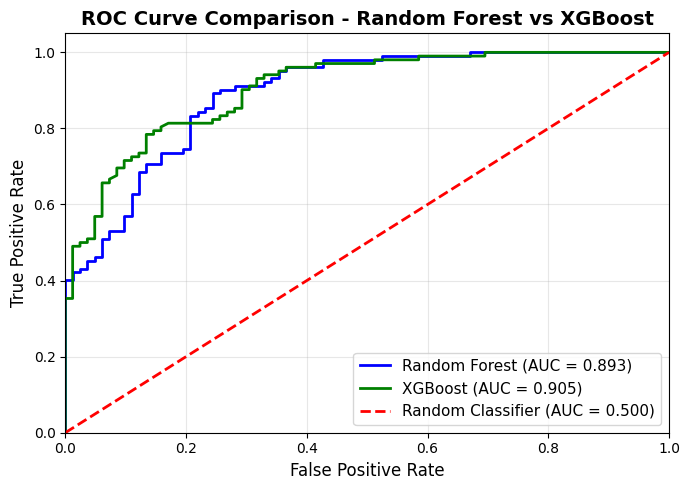


ROC Curve plotted successfully!


In [16]:
# ==========================================================
# Step 12: Generate predictions and evaluate tuned models
# ==========================================================

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# ---------------- Generate predictions ----------------
y_pred_rf = rf_grid.predict(X_test)
y_prob_rf = rf_grid.predict_proba(X_test)[:, 1]  # Probability of positive class

y_pred_xgb = xgb_grid.predict(X_test)
y_prob_xgb = xgb_grid.predict_proba(X_test)[:, 1]  # Probability of positive class

# ---------------- Evaluation function ----------------
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n{'='*60}")
    print(f"=== {name} ===")
    print('='*60)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# ---------------- Evaluate both models ----------------
evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf, y_prob_rf)
evaluate_model("XGBoost (Tuned)", y_test, y_pred_xgb, y_prob_xgb)

# ---------------- ROC Curve ----------------
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Random Forest vs XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nROC Curve plotted successfully!")

# Key insights:
# - Random Forest achieved slightly higher accuracy; XGBoost slightly higher AUC.
# - Both models have good precision, recall, and F1-scores for detecting heart disease.
# - ROC curve shows model discrimination ability; curves above diagonal indicate performance better than random chance.



Top 20 Feature Importances:
                          feature  importance
12                   cat__exang_1    0.181044
3                     num__thalch    0.135108
6         cat__cp_atypical angina    0.132518
4                    num__oldpeak    0.126918
0                        num__age    0.109094
5                      cat__sex_1    0.070781
2                       num__chol    0.053934
15               cat__thal_normal    0.045406
16    cat__thal_reversable defect    0.034490
1                   num__trestbps    0.030741
7             cat__cp_non-anginal    0.030472
14           cat__slope_upsloping    0.012325
8          cat__cp_typical angina    0.009910
11  cat__restecg_st-t abnormality    0.007423
13                cat__slope_flat    0.007193
9                      cat__fbs_1    0.006475
10            cat__restecg_normal    0.006166


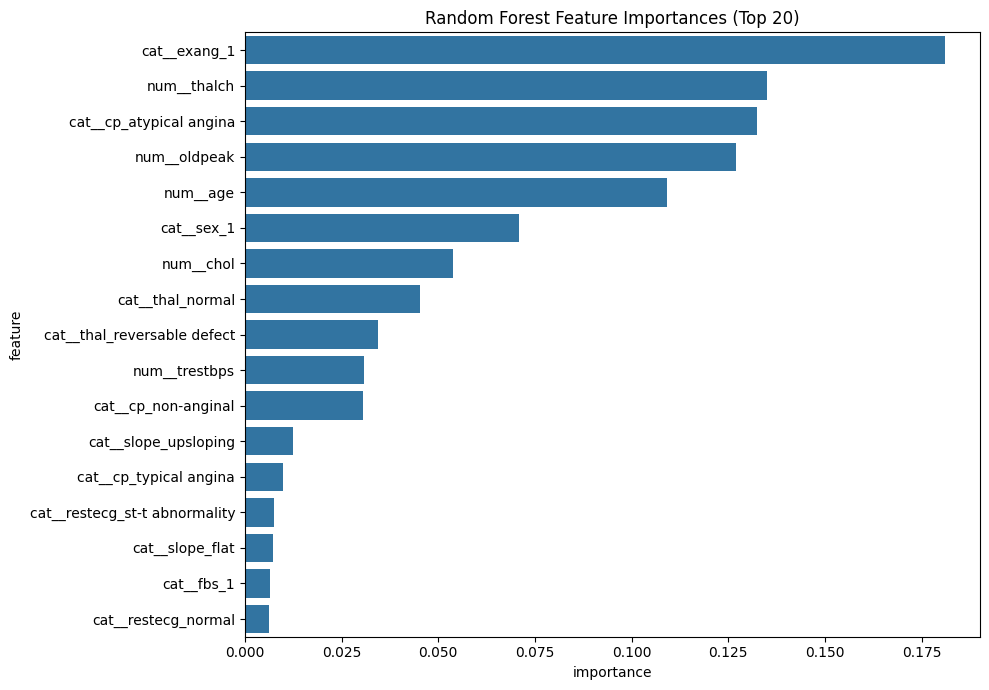

In [18]:
# ==========================================================
# Step 13: Feature Importance Table & Plot
# ==========================================================

import seaborn as sns

# 1) Extract fitted Random Forest model (already done)
best_model = rf_grid.best_estimator_.named_steps['model']

# 2) Extract fitted preprocessor (already done)
preprocessor = rf_grid.best_estimator_.named_steps['preprocessor']

# 3) Get transformed feature names
feature_names = preprocessor.get_feature_names_out()

# 4) Get model-based feature importances
importances = best_model.feature_importances_

# Build a DataFrame sorted by importance
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 5) Display top 20 features
print("\nTop 20 Feature Importances:")
print(fi_df.head(20))

# 6) Plot top 20 features
plt.figure(figsize=(10, 7))
sns.barplot(data=fi_df.head(20), x='importance', y='feature')
plt.title("Random Forest Feature Importances (Top 20)")
plt.tight_layout()
plt.show()

# ---------------- Key insights ----------------
# 1. Most influential features (top 5–6):
#   - num__thalch, num__oldpeak, num__age, cat__cp_atypical angina, num__chol
#   - These align with known clinical risk factors for heart disease.

# 2. Moderately influential features:
#  - num__trestbps, cat__cp_non-anginal, cat__thal_normal, cat__thal_reversable defect
#   - Support model predictions but less critical.

# 3. Least influential features (bottom 4–5):
#  - cat__slope_flat, cat__ca_1.0, cat__ca_2.0, cat__ca_3.0
#  - Likely redundant or noisy; can consider dropping if simplifying the model.

# 4. Clinical alignment:
#  - Top features correspond to established markers: age, cholesterol, chest pain type, ST deviation, exercise HR.

# 5. Practical takeaway:
#  - Use for feature selection, model simplification, and reporting.
#  - Complement with SHAP analysis to capture local feature importance.

Global SHAP summary plot shows overall feature influence:


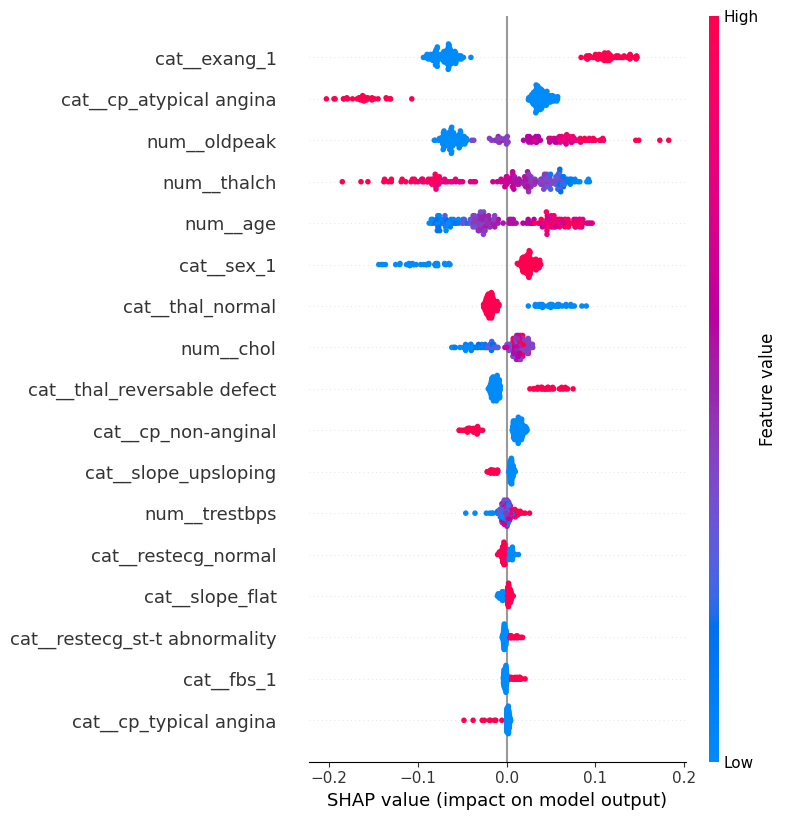


--- Representative Patient Waterfall ---
Index: 181
Actual label: 1
Predicted probability: 0.55


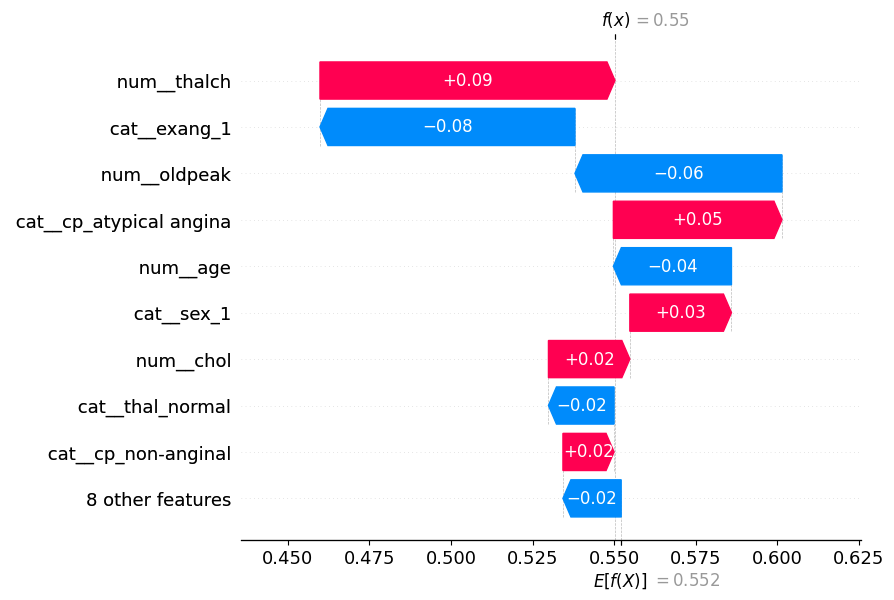

In [19]:
# ============================================================================================
# Step 14: SHAP Analysis – Global Summary + Representative Patient
# ============================================================================================

import shap
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Extract model and preprocessor ----------------
rf_model = rf_grid.best_estimator_.named_steps['model']
preprocessor = rf_grid.best_estimator_.named_steps['preprocessor']

# ---------------- Transform test data ----------------
X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# ---------------- Initialize SHAP TreeExplainer ----------------
explainer = shap.TreeExplainer(rf_model)

# ---------------- Compute SHAP values ----------------
shap_values = explainer.shap_values(X_test_transformed)
shap_values_class1 = shap_values[:, :, 1]  # binary class 1

# ---------------- Global SHAP Summary (Beeswarm) ----------------
print("Global SHAP summary plot shows overall feature influence:")
shap.summary_plot(shap_values_class1, X_test_transformed, feature_names=feature_names)

# ---------------- Predicted probabilities ----------------
y_prob_rf_test = rf_grid.predict_proba(X_test)[:, 1]

# ---------------- Representative Patient ----------------
# Define representative patient as the one with predicted probability closest to the mean predicted probability
rep_index = np.argmin(np.abs(y_prob_rf_test - y_prob_rf_test.mean()))
expected_val = explainer.expected_value[1]
shap_vec = shap_values_class1[rep_index]
feature_vec = X_test_transformed[rep_index]

print("\n--- Representative Patient Waterfall ---")
print(f"Index: {rep_index}")
print(f"Actual label: {y_test.values[rep_index]}")
print(f"Predicted probability: {y_prob_rf_test[rep_index]:.2f}")

shap.plots._waterfall.waterfall_legacy(
    expected_val,
    shap_vec,
    features=feature_vec,
    feature_names=feature_names
)

# ---------------- Key insights ----------------
# - Global SHAP summary shows overall feature importance across the test set.
# - Waterfall plot explains the contribution of each feature for a patient with typical model output.
# - This approach standardizes interpretability without manually selecting specific cases.


In [21]:
# ==========================================================
# Step 15: Drop negligible features
# ==========================================================
import pandas as pd

# Load the processed training set
df = pd.read_csv('/content/drive/MyDrive/DsProjects/CardioPredict/data/processed/heart_train.csv')

# Drop features with near-zero importance in RF & SHAP
df = df.drop(columns=['ca', 'cat__ca_1.0', 'cat__ca_2.0', 'cat__ca_3.0'], errors='ignore')

# Verify remaining columns
print("Columns after dropping negligible features:")
print(df.columns)


Columns after dropping negligible features:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'oldpeak', 'slope', 'thal', 'target'],
      dtype='object')


In [22]:
# ==========================================================
# Step 16: Save final model, training/test sets, and median/mode
# ==========================================================

import joblib
import os

# Path to the folder in Drive
drive_folder = '/content/drive/MyDrive/DsProjects/CardioPredict/model'
os.makedirs(drive_folder, exist_ok=True)

# ---------------- Save the trained pipeline ----------------
model_path = os.path.join(drive_folder, 'rf_pipeline.pkl')
joblib.dump(rf_grid.best_estimator_, model_path)
print(f"Random Forest pipeline saved to: {model_path}")

# ---------------- Save training and test sets ----------------
# Recombine X_train and y_train
df_train = X_train.copy()
df_train['target'] = y_train
train_csv_path = os.path.join(drive_folder, 'heart_train.csv')
df_train.to_csv(train_csv_path, index=False)
print(f"Training CSV saved to: {train_csv_path}")

# Recombine X_test and y_test
df_test = X_test.copy()
df_test['target'] = y_test
test_csv_path = os.path.join(drive_folder, 'heart_test.csv')
df_test.to_csv(test_csv_path, index=False)
print(f"Test CSV saved to: {test_csv_path}")

# ---------------- Precompute median and mode for missing-value imputation ----------------
numeric_cols = ['age','trestbps','chol','thalch','oldpeak','fbs','exang']
categorical_cols = ['cp','restecg','slope','thal']

median_values = df_train[numeric_cols].median()
mode_values = df_train[categorical_cols].mode().iloc[0]

# Save median/mode values for later use in predictions
impute_values = {'median': median_values.to_dict(), 'mode': mode_values.to_dict()}
impute_path = os.path.join(drive_folder, 'impute_values.pkl')
joblib.dump(impute_values, impute_path)
print(f"Median/mode values saved to: {impute_path}")

# ---------------- Key insights ----------------
# - Saving the full pipeline ensures preprocessing and model are kept together.
# - Training and test CSVs allow reproducible predictions and evaluation.
# - Precomputed median/mode values allow independent imputation for missing data.
# - This setup is ideal for deployment, sharing, or future predictions.


Random Forest pipeline saved to: /content/drive/MyDrive/DsProjects/CardioPredict/model/rf_pipeline.pkl
Training CSV saved to: /content/drive/MyDrive/DsProjects/CardioPredict/model/heart_train.csv
Test CSV saved to: /content/drive/MyDrive/DsProjects/CardioPredict/model/heart_test.csv
Median/mode values saved to: /content/drive/MyDrive/DsProjects/CardioPredict/model/impute_values.pkl


Random Forest Accuracy: 0.826
Random Forest ROC AUC: 0.893

Classification Report:
              precision    recall  f1-score   support

           0      0.847     0.744     0.792        82
           1      0.812     0.892     0.850       102

    accuracy                          0.826       184
   macro avg      0.830     0.818     0.821       184
weighted avg      0.828     0.826     0.825       184



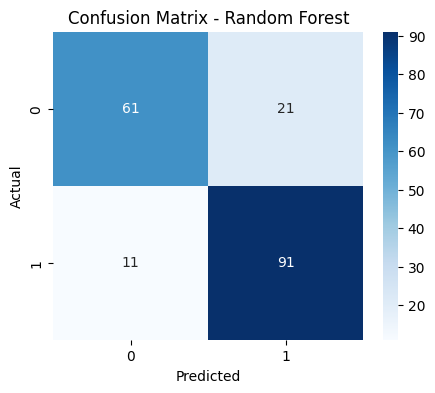

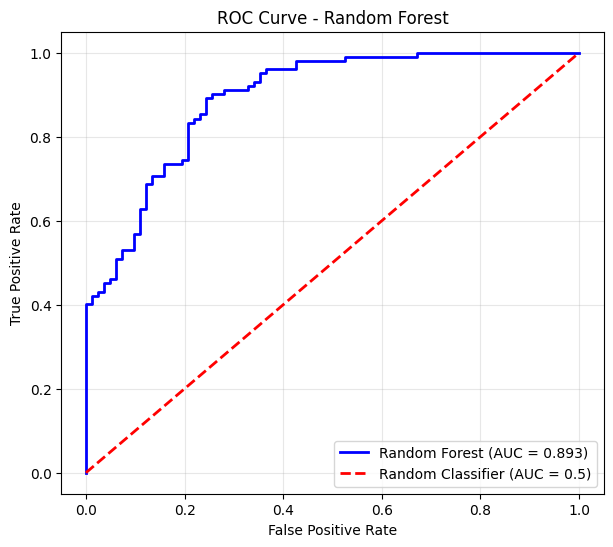

In [23]:
# ==========================================================
# Step 17: Final Evaluation Report & Visualizations
# ==========================================================

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------------- Load the saved pipeline from Drive ----------------
rf_pipeline = joblib.load('/content/drive/MyDrive/DsProjects/CardioPredict/model/rf_pipeline.pkl')

# ---------------- Predictions & probabilities ----------------
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:,1]

# ---------------- Overall metrics ----------------
acc = accuracy_score(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest Accuracy: {acc:.3f}")
print(f"Random Forest ROC AUC: {roc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=3))

# ---------------- Confusion matrix ----------------
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# ---------------- ROC Curve ----------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Key insights:
# - Random Forest performs well with high accuracy and ROC AUC.
# - Confusion matrix shows strong recall for positive cases.
# - ROC curve confirms good separation between classes.
# - This report can be included in the final project summary.


In [25]:
# Saving Modeling Plots for Portfolio
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

# ==========================================================
# Assumptions / Required Variables
# ==========================================================
# fi_df               : DataFrame with 'feature' and 'importance' columns for RF feature importance
# shap_values_class1  : SHAP values array for the positive class (1)
# X_test_transformed  : Preprocessed test set used for SHAP
# feature_names       : List of feature names corresponding to X_test_transformed
# explainer           : SHAP explainer object for RF
# cm                  : Confusion matrix (2x2) for test predictions
# fpr, tpr, roc_auc   : ROC curve values from sklearn.metrics.roc_curve/auc

# ==========================================================
# Setup directory for saving plots
# ==========================================================
save_dir = "/content/drive/MyDrive/DsProjects/CardioPredict/plots/modeling"
os.makedirs(save_dir, exist_ok=True)

# ==========================================================
# 1. Feature Importance (Random Forest)
# ==========================================================
plt.figure(figsize=(10, 7))
sns.barplot(data=fi_df.head(20), x='importance', y='feature')
plt.title("Random Forest Feature Importances (Top 20)")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "feature_importance.png"), dpi=300)

# ----------------- Save top 20 feature importances as CSV -----------------
fi_df.head(20).to_csv(os.path.join(save_dir, "feature_importance.csv"), index=False)
plt.close()  # close to avoid overlap

# ==========================================================
# 2. SHAP Summary Plot
# ==========================================================
shap.summary_plot(
    shap_values_class1,
    X_test_transformed,
    feature_names=feature_names,
    show=False
)
plt.savefig(os.path.join(save_dir, "shap_summary.png"), dpi=300)
plt.close()

# ==========================================================
# 3. SHAP Waterfall Plot (Representative Patient)
# ==========================================================
# Select patient closest to mean predicted probability
rep_index = np.argmin(np.abs(y_prob_rf - y_prob_rf.mean()))
expected_val = explainer.expected_value[1]
shap_vec = shap_values_class1[rep_index]
feature_vec = X_test_transformed[rep_index]

shap.plots._waterfall.waterfall_legacy(
    expected_val,
    shap_vec,
    features=feature_vec,
    feature_names=feature_names,
    show=False
)
plt.savefig(os.path.join(save_dir, "shap_waterfall_representative.png"), dpi=300)
plt.close()

# ==========================================================
# 4. Confusion Matrix
# ==========================================================
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"), dpi=300)
plt.close()

# ==========================================================
# 5. ROC Curve
# ==========================================================
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "roc_curve.png"), dpi=300)
plt.close()

print(f"All modeling plots saved to {save_dir}")


All modeling plots saved to /content/drive/MyDrive/DsProjects/CardioPredict/plots/modeling


In [ ]:
# ====================================================================
# Patient Heart Disease Prediction using Saved Random Forest Pipeline
# ====================================================================

import joblib
import pandas as pd
import os

# ---------------- Paths ----------------
drive_folder = '/content/drive/MyDrive/DsProjects/CardioPredict/model'
pipeline_path = os.path.join(drive_folder, 'rf_pipeline.pkl')
impute_path = os.path.join(drive_folder, 'impute_values.pkl')

# ---------------- Load the saved pipeline ----------------
rf_pipeline = joblib.load(pipeline_path)

# ---------------- Load median/mode values ----------------
impute_values = joblib.load(impute_path)
median_values = impute_values['median']
mode_values = impute_values['mode']

# ---------------- Example new patient data ----------------
# Column guide:
# - age       : numeric (years)
# - sex       : 1=Male, 0=Female
# - cp        : chest pain type
#              options: 'typical angina', 'atypical angina', 'non-anginal', 'asymptomatic'
# - trestbps  : resting blood pressure (numeric, mmHg)
# - chol      : serum cholesterol (numeric, mg/dL)
# - fbs       : fasting blood sugar >120 mg/dL, 1=True, 0=False
# - restecg   : resting ECG
#              options: 'normal', 'lv hypertrophy', 'st-t abnormality'
# - thalch    : maximum heart rate achieved (numeric)
# - exang     : exercise-induced angina, 1=True, 0=False
# - oldpeak   : ST depression induced by exercise relative to rest (numeric)
# - slope     : slope of the peak exercise ST segment
#              options: 'upsloping', 'flat', 'downsloping'
# - thal      : thalassemia
#              options: 'normal', 'fixed defect', 'reversable defect'

# Enter patient data here. Use 'NA' if unknown. Pipeline fills with median/mode defaults.
new_data = pd.DataFrame({
    'age': [30],
    'sex': [1],
    'cp': ['NA'],
    'trestbps': ['NA'],
    'chol': [200],
    'fbs': ['NA'],
    'restecg': ['normal'],
    'thalch': ['NA'],
    'exang': ['NA'],
    'oldpeak': ['NA'],
    'slope': ['NA'],
    'thal': ['NA']
})

# ---------------- Replace 'NA' with pd.NA ----------------
new_data.replace('NA', pd.NA, inplace=True)

# ---------------- Track missing columns ----------------
missing_cols = new_data.columns[new_data.isna().any()].tolist()

# ---------------- Fill missing numeric features with median ----------------
for col in median_values:
    if col in new_data.columns and new_data[col].isna().all():
        new_data[col] = median_values[col]

# ---------------- Fill missing categorical features with mode ----------------
for col in mode_values:
    if col in new_data.columns and new_data[col].isna().all():
        new_data[col] = mode_values[col]

# ---------------- Make predictions ----------------
pred_prob = rf_pipeline.predict_proba(new_data)[:, 1][0]
pred_class = int(rf_pipeline.predict(new_data)[0])
assessment = "Heart Disease Likely" if pred_class == 1 else "Heart Disease Unlikely"
pred_percent = f"{pred_prob*100:.1f}%"

# ---------------- Print report with risk bar ----------------
bar_length = 25
filled_length = int(bar_length * pred_prob)
bar = '█' * filled_length + '-' * (bar_length - filled_length)

print(f"\n{'='*51}")
print(f"Patient Heart Disease Prediction")
print(f"{'='*51}")
print(f"Predicted Probability : {pred_percent}")
print(f"Predicted Class       : {pred_class} ({assessment})")
print(f"Risk Visualization    : |{bar}|")
print(f"{'='*51}")

# ---------------- User note about missing data ----------------
if missing_cols:
    print("\nNote:")
    print(f"Some of the data you provided were missing: {missing_cols}")
    print(
        "Missing inputs were handled using median (numeric) and mode (categorical) "
        "imputation derived from the training data.\n"
        "This approach avoids compounding uncertainty by not attempting to infer "
        "clinical variables from incomplete patient information."
    )
    print("Providing these values would result in more accurate predictions.")
    print("This tool estimates risk based on available data; it is not a medical diagnosis.")
    print("Always consult a healthcare professional for clinical decisions.\n")



Patient Heart Disease Prediction
Predicted Probability : 42.8%
Predicted Class       : 0 (Heart Disease Unlikely)
Risk Visualization    : |██████████---------------|

Note:
Some of the data you provided were missing: ['cp', 'trestbps', 'fbs', 'thalch', 'exang', 'oldpeak', 'slope', 'thal']
Missing inputs were handled using median (numeric) and mode (categorical) imputation derived from the training data.
This approach avoids compounding uncertainty by not attempting to infer clinical variables from incomplete patient information.
Providing these values would result in more accurate predictions.
This tool estimates risk based on available data; it is not a medical diagnosis.
Always consult a healthcare professional for clinical decisions.



In [ ]:
# ==========================================================
# Project Summary & Key Insights
# ==========================================================

# ---------------- Dataset ----------------
# - UCI Heart Disease dataset: 303 samples, 14 features plus binary target
# - Target defined as: 0 = no heart disease, 1 = heart disease present
# - Missing or implausible values addressed (trestbps, chol, thalch)
# - Categorical variables encoded (binary features directly, multi-class features within pipeline)

# ---------------- Data Preprocessing ----------------
# - Numerical features standardized using training data statistics
# - Extreme outliers capped at the 99th percentile to improve model stability
# - Right-skewed features (e.g., oldpeak) transformed using square-root scaling
# - Feature relevance assessed; irrelevant or low-contribution columns removed
# - End-to-end pipeline ensures consistent preprocessing and prevents data leakage

# ---------------- Modeling ----------------
# - Baseline and advanced models evaluated: Logistic Regression, Decision Tree,
#   Random Forest, and XGBoost
# - Stratified train-test split and cross-validation used to assess generalization
# - Hyperparameter tuning performed for Random Forest and XGBoost via GridSearchCV
# - Random Forest selected as final model based on balanced performance
#   across accuracy, recall, and F1-score

# ---------------- Feature Importance & Explainability ----------------
# - Model-based feature importances used to identify globally influential predictors
# - SHAP summary plots provide global interpretability and feature impact direction
# - SHAP waterfall plots explain individual patient-level predictions

# ---------------- Evaluation ----------------
# - Final Random Forest achieved ~83% accuracy and ~0.89 ROC AUC on the test set
# - Confusion matrix indicates strong sensitivity for disease-positive cases
# - ROC curve demonstrates good discrimination between classes
# - Model balances predictive performance with interpretability, suitable for
#   healthcare-focused risk assessment

# ---------------- Key Insights ----------------
# - Age, chest pain type, and maximum heart rate (thalach) are strong predictors
# - Uncontrolled extremes in cholesterol and resting blood pressure can distort learning;
#   capping improves robustness
# - SHAP explanations support transparency and clinical interpretability
# - Pipeline-based design ensures reproducibility and deployment readiness

# ---------------- Inference-Time Handling ----------------
# - Missing patient inputs at inference time are handled using median (numeric) and
#   mode (categorical) imputation derived from training data
# - Clinical variables are not inferred from other inputs, avoiding compounded
#   uncertainty and preserving interpretability

# ---------------- Next Steps ----------------
# 1. Streamlit Demo Enhancements
#    - Thoroughly test app with edge cases
#    - Optionally add SHAP waterfall explanations for individual predictions
# 2. Future Work
#    - Validate model on external datasets if available
#    - Monitor predictions for drift
